## 리뷰 데이터셋 이진 분류 (긍정 or 부정)

In [ ]:
from tensorflow import keras
from keras.datasets import imdb
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences

# IMDB 리뷰 데이터셋 로드 (최대 500개의 빈도 높은 단어만 사용)
(train_input, train_target), (test_input, test_target) =\
    imdb.load_data(num_words=500)

# 훈련 데이터를 다시 훈련/검증 세트로 분할 (80% 훈련, 20% 검증)
train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42
)

# 각 샘플의 길이를 100으로 맞춰 패딩 (부족하면 0으로 채움)
train_seq = pad_sequences(train_input, maxlen=100)
val_seq = pad_sequences(val_input, maxlen=100)

# 확인용 출력: (훈련 샘플 수, 시퀀스 길이), (검증 샘플 수, 시퀀스 길이)
print(train_seq.shape, val_seq.shape)

(20000, 100) (5000, 100)


In [ ]:
from keras.layers import *

# 층 구성
model = keras.Sequential()
model.add(Input(shape=(100,)))
model.add(Embedding(500, 16))  # Embedding: 최대 500개의 단어를 16차원 벡터로 변환
model.add(LSTM(8))  # activation='tanh' -> 기본값, 하이퍼 탄젠트 / 8개의 밀집 벡터로 만듦 
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 16)        │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 8)              │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,809 (34.41 KB)

 Trainable params: 8,809 (34.41 KB)

 Non-trainable params: 0 (0.00 B)

LSTM은 다음 4개의 게이트를 갖고 있습니다:

- 입력 게이트 (input gate)
- 출력 게이트 (output gate)
- 망각 게이트 (forget gate)
- 후보 셀 상태 (cell candidate)

따라서, LSTM의 총 파라미터 수는:\
파라미터 수 = 4 × [(입력 차원 × 출력 차원) + (출력 차원 × 출력 차원) + 출력 차원]

In [4]:
# 모델 컴파일: 최적화 알고리즘, 손실 함수, 평가 지표 설정
model.compile(
    optimizer='adam',                 # 가중치 업데이트에 Adam 옵티마이저 사용
    loss='binary_crossentropy',       # 이진 분류 문제에 적합한 손실 함수
    metrics=['accuracy']              # 모델 성능을 측정할 지표로 정확도 사용
)

# 콜백 함수 설정
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    'best-embedding-model.keras',     # 최적 모델을 저장할 파일 경로
    save_best_only=True               # 검증 손실이 가장 낮은 모델만 저장
)

# 조기 종료 설정
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=3,                       # 검증 손실이 상승하면 3번까지 참고, 넘어가면 학습 중단
    restore_best_weights=True         # 학습 중 가장 좋은 모델 가중치를 복원
)

# 모델 학습 시작
hist = model.fit(
    train_seq, train_target,          # 훈련 입력과 레이블
    epochs=100,                       # 최대 100번 반복 학습
    validation_data=(val_seq, val_target),  # 검증 데이터로 성능 평가
    callbacks=[checkpoint_cb, early_stopping_cb]  # 콜백 적용
)

Epoch 1/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6499 - loss: 0.6167 - val_accuracy: 0.7810 - val_loss: 0.4692
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7817 - loss: 0.4592 - val_accuracy: 0.7926 - val_loss: 0.4402
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7960 - loss: 0.4306 - val_accuracy: 0.8000 - val_loss: 0.4329
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8087 - loss: 0.4155 - val_accuracy: 0.8020 - val_loss: 0.4280
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8119 - loss: 0.4016 - val_accuracy: 0.8028 - val_loss: 0.4286
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8104 - loss: 0.4046 - val_accuracy: 0.8094 - val_loss: 0.4202
Epoch 7/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8192 - loss: 0.3830 - val_accuracy: 0.8038 - val_loss: 0.4269
Epoch 8/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8228 - loss: 0.3800 - val_accu

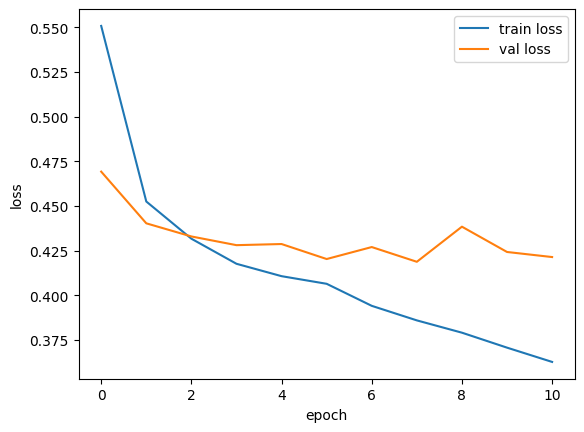

In [5]:
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

dropout 추가, 은닉층 추가

In [ ]:
# 층 구성
model = keras.Sequential()
model.add(Input(shape=(100,)))
model.add(Embedding(500, 16))  # Embedding: 최대 500개의 단어를 16차원 벡터로 변환
model.add(LSTM(     # activation='tanh' -> 기본값, 하이퍼 탄젠트 / 8개의 밀집 벡터로 만듦
    8,
    dropout=0.2,    # 은닉층 유닛 20%를 랜덤으로 비활성화
    return_sequences=True))   # 모든 은닉 상태 출력을 전달
model.add(LSTM(     # activation='tanh' -> 기본값, 하이퍼 탄젠트 / 8개의 밀집 벡터로 만듦
    8,
    dropout=0.2,    # 은닉층 유닛 20%를 랜덤으로 비활성화
    return_sequences=False))   # 기본값 False - 마지막 은닉 상태 출력만 전달
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 16)        │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 8)         │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 8)              │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,353 (36.54 KB)

 Trainable params: 9,353 (36.54 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# 모델 컴파일: 최적화 알고리즘, 손실 함수, 평가 지표 설정
model.compile(
    optimizer='adam',                 # 가중치 업데이트에 Adam 옵티마이저 사용
    loss='binary_crossentropy',       # 이진 분류 문제에 적합한 손실 함수
    metrics=['accuracy']              # 모델 성능을 측정할 지표로 정확도 사용
)

# 콜백 함수 설정
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    'best-embedding-model.keras',     # 최적 모델을 저장할 파일 경로
    save_best_only=True               # 검증 손실이 가장 낮은 모델만 저장
)

# 조기 종료 설정
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=3,                       # 검증 손실이 상승하면 3번까지 참고, 넘어가면 학습 중단
    restore_best_weights=True         # 학습 중 가장 좋은 모델 가중치를 복원
)

# 모델 학습 시작
hist = model.fit(
    train_seq, train_target,          # 훈련 입력과 레이블
    epochs=100,                       # 최대 100번 반복 학습
    validation_data=(val_seq, val_target),  # 검증 데이터로 성능 평가
    callbacks=[checkpoint_cb, early_stopping_cb]  # 콜백 적용
)

Epoch 1/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.6247 - loss: 0.6254 - val_accuracy: 0.7820 - val_loss: 0.4657
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.7700 - loss: 0.4844 - val_accuracy: 0.7774 - val_loss: 0.4569
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.7947 - loss: 0.4530 - val_accuracy: 0.7922 - val_loss: 0.4522
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.7994 - loss: 0.4309 - val_accuracy: 0.8000 - val_loss: 0.4258
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.8108 - loss: 0.4183 - val_accuracy: 0.8030 - val_loss: 0.4256
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.8157 - loss: 0.4116 - val_accuracy: 0.8060 - val_loss: 0.4209
Epoch 7/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.8113 - loss: 0.4072 - val_accuracy: 0.8120 - val_loss: 0.4175
Epoch 8/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.8142 - loss: 0.4038 -

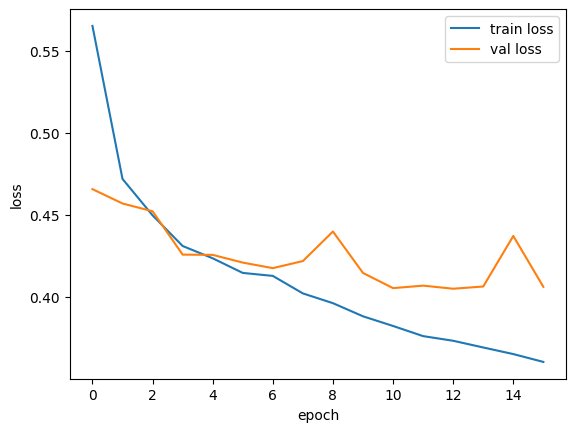

In [8]:
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

가벼운 모델 만들기!